# Normalized Vegetation Index (NDVI)

The Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared **nir** (which vegetation strongly reflects) and **red** light (which vegetation absorbs). NDVI always ranges from -1 to +1.

* **Negative Values:** It is most likely water.
* **Values Close to 1:** There is a high possibility that they are dense green leaves.
* **Values Close to 0:** There are no green leaves and it could even be an urbanized area.

<img src="resources/ndvi_example.png" alt="Drawing" style="width: 400px;"/>

## Content

1. Undertading Landsat 8 OLI LASRC Scene Data
2. Query Datacube
3. Cloud Masking
4. NDVI Calculation

## Undertading Landsat 8 OLI LASRC Scene Data

The Landsat 8 OLI LASRC scenes taken in this work are images belonging to **Collection 1 - Level 2 (On demand)** of the USGS Earth Explorer image catalog. In particular, Level 2 scenes apply atmospheric corrections called **Surface Reflectance (SR) Correction**. These corrections mitigate the effect of gases and aerosols found in the atmosphere, because gases and aerosols affect the reflectance emited by the earth and read by the satellite (sensor). Atmospheric corrections are carried out in Landsat 8 OLI scenes by the **LASRC (Landsat Surface Reflectance Code) algorithm**.

During the generation of surface reflectance corrected scenes, the LASRC algorithm evaluates the quality of each pixel, the information of this evaluation is recorded in 3 bands (`sr_aerosol`, `pixel_qa`, `radsat_qa`) that are additionally generated at the end of the reflectance correction.

Information on the valid values for each band is found below:

* band_1 (coastal_aerosol): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_2 (blue): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_3 (green): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_4 (red): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_5 (nir): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_6 (swir1): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_7 (swir2): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* pixel_qa (pixel_qa): rango=0,32768 rango_valido=0,32768
* sr_aerosol (sr_aerosol_qa, aerosol_qa, aerosol): rango=0,255; rango_valido=0,255
* radsat_qa (radsat_qa): rango=0,32768 rango_valido=0,32768

#### References

1. [Designación de Bandas para Satelites Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products)
2. [Evaluación de la Calidad de los Pixeles en Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8-surface-reflectance-quality-assessment?qt-science_support_page_related_con=1#qt-science_support_page_related_con)
3. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)

In [52]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import datacube

In [37]:
%%time

dc = datacube.Datacube(app="NDVI")

xarr = dc.load(
    # Satellite 
    product="LS8_OLI_LASRC",
    
    # Area to be requested 0.23738925
    latitude=(3.75702418296, 3.99441343296),
    longitude=(-70.402981323, -70.166735698),
    # Time format (YYYY-MM-DD)
    # time=("2017-12-21","2017-12-23"),

    # Image spectral bands
    measurements=['red', 'nir','pixel_qa'],
    output_crs='EPSG:4326',
    resolution=(-0.000271302,0.000269995)
)

xarr

CPU times: user 343 ms, sys: 125 ms, total: 468 ms
Wall time: 307 ms


<xarray.Dataset>
Dimensions:      (latitude: 876, longitude: 876, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2017-12-22T14:54:24
  * latitude     (latitude) float64 3.995 3.994 3.994 ... 3.758 3.757 3.757
  * longitude    (longitude) float64 -70.4 -70.4 -70.4 ... -70.17 -70.17 -70.17
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 592 567 448 ... 302 265 264
    nir          (time, latitude, longitude) int16 2438 2627 3115 ... 3842 3850
    pixel_qa     (time, latitude, longitude) int32 322 322 322 ... 322 322 322
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

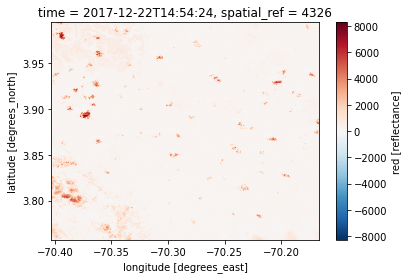

In [33]:
# Imagen de una sola banda
xarr.red.plot()

# Valor de un pixel en el tiempo
# xarr.red[0][0][0]

## Máscara de Nubes

Las nubes y las condiciones atmosféricas presentan un desafío importante cuando se trabaja con datos de teledetección multiespectrales. Las nubes y sombras extremas pueden generar datos no utilizables. En principio las nubes dispersan toda la luz emitida por el sol provocando que regrese al sensor sin datos relevantes. Por otro lado, la luz es absorbida o bloqueada, en este caso la cantidad de datos leídos desde la superficie terrestre también es irrelevante.

Las imágenes Landsat corregidas con **Superficie de Reflectancia** vienen con capas de calidad (pixel_qa) que permiten detectar la presencia de nubes, sombras e incluso agua en el monitoreo. Esta capa nos permitirá identificar y eliminar píxeles que no son útiles para el análisis. La siguiente tabla muestra la representación de cada uno de los valores que se pueden encontrar para cada píxel de la banda `pixel_qa`.

| Attribute                | Pixel Value                                                     |
|--------------------------|-----------------------------------------------------------------|
| Fill                     | 1                                                               |
| Clear                    | 322, 386, 834, 898, 1346                                        |
| Water                    | 324, 388, 836, 900, 1348                                        |
| Cloud shadow             | 328, 392, 840, 904, 1350                                        |
| Snow/ice                 | 336, 368, 400, 432, 848, 880, 912, 944, 1352                    |
| Cloud                    | 352, 368, 416, 432, 480, 864, 880, 928, 944, 992                |
| Low confidence cloud     | 322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880      |
| Medium confidence cloud  | 386, 388, 392, 400, 416, 432, 898, 900, 904, 928, 944           |
| High confidence cloud    | 480, 992                                                        |
| Low confidence cirrus    | 322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480 |
| High confidence cirrus   | 834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992 |
| Terrain occlusion        | 1346, 1348, 1350, 1352                                          |


#### References

1. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)
2. [Clean Remote Sensing Data in Python - Clouds, Shadows & Cloud Masks](https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/)

In [34]:
def cloud_mask(band,pixel_qa):
    """
    Enmascara o hace igual a NaN aquellos pixeles que no son 
    relevantes para el análisis, como aquellos pixeles donde se
    presentan nubes, nieve en todas sus modalidades.
    
    Args:
        band (xarray.DataArray): Banda o respuesta espectral (red,blue,green,etc).
        pixel_qa (xarray.DataArray): The pixel quality band.
        
    Returns:
        xarray.DataArray: Matrix donde las nubes ha sido removidas (nodata). 
    """
    
    nodata=-9999
    
    # VALORES VALIDOS PARA ANALISIS PRESENTES EN 
    # LA BANDA PIXEL_QA
    
    # Para este caso únicamente nos interesa conservar 
    # aquellos pixeles cuya obvercación es clara y 
    # además pixeles que pueden mostrar información 
    # acerca del agua
    clear = [322, 386, 834, 898, 1346]
    water = [324, 388, 836, 900, 1348]
    valid_values = clear + water

    # Aquellos pixeles cuyos valor esten en valid_values tendran un
    # valor de True en la corrspondiente posición en la matrix mask_1 
    # indicando que son pixeles validos para analisis. Aquellos pixeles 
    # cuyos valores no esten en valid_values tendran un valor de False 
    # en mask_1.
    mask_1 = np.isin(pixel_qa.values, valid_values)

    # Marca como True aquellos pixeles que tienen información, es decir, 
    # no son igual a nodata=-9999.
    has_information = band != nodata

    # Aquellos pixeles que tienen información (has_information[i][j] = True)
    # y son pixeles validos mask_1[i][j] = True, seguirán siendo válidos, es
    # decir, mask_2[i][j] = True. En caso contrarion mask_2[i][j] = False.
    mask_2 = np.logical_and(has_information,mask_1)

    # Para pixeles validos mask_2[i][j] = True, entonces 
    # new_band_data_array[i][j] = band_data_array[i][j]. 
    # En caso contrario, new_band_data_array[i][j] = NaN.
    new_band_data_array = np.where(mask_2,band,np.nan)
    return new_band_data_array

<Figure size 28800x43200 with 0 Axes>

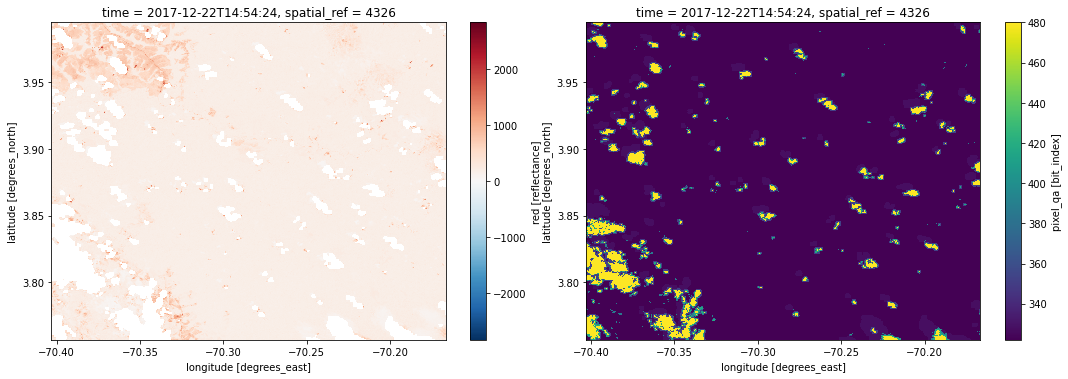

In [50]:
xarr.red.values = cloud_mask(xarr.red,xarr.pixel_qa)
xarr.nir.values = cloud_mask(xarr.nir,xarr.pixel_qa)

plt.figure(figsize=(400,600))
fig, axes = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout()

xarr.red.plot(ax=axes[0])
# xarr.nir.plot(ax=axes[1])
xarr.pixel_qa.plot(ax=axes[1])

## NDVI Calculation 



### Referencia

1. [What is NDVI (Normalized Difference Vegetation Index)?](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/)

In [53]:
def ndvi(red,nir):
    """Indice de Vegetación Normalizado.
    
    Args:
        red (xarray.DataArray): Banda red .
        nir (xarray.DataArray): Banda nir.
        
    Returns:
        xarray.DataArray: Matr
    """
    # Obteniendo los valores de las bandas. 
    # los valores son np.array
    period_red = red.values
    period_nir = nir.values

    # Si los pixeles en 'red' o 'nir' tiene valoes NaN entonces 
    # mask_nan = True
    mask_nan=np.logical_or(np.isnan(period_red), np.isnan(period_nir))

    # NDVI computation
    period_nvdi = (period_nir-period_red) / (period_nir+period_red)

    # Remover pixeles invalidos
    period_nvdi[mask_nan] = np.nan

    # Remover valores mayores de 1 e inferiores a -1
    # Ya que el indice está definido entre -1 y 1.
    period_nvdi[period_nvdi>1] = np.nan
    period_nvdi[period_nvdi<-1] = np.nan

    data_array = xr.DataArray(data=period_nvdi)
    return data_array

In [56]:
mask_nan=np.logical_or(np.isnan(xarr.red), np.isnan(xarr.nir))

xarr['ndvi'] = xarr.red-xarr.nir / xarr.red+xarr.nir
xarr['ndvi'][mask_nan] = np.nan
xarr['ndvi'][mask_nan] = np.nan
xarr['ndvi'][mask_nan] = np.nan

<xarray.DataArray (time: 1, latitude: 876, longitude: 876)>
array([[[3025.88175676, 3189.36684303, 3556.046875  , ...,
         2979.18316832, 3291.77083333, 3144.04545455],
        [2681.628     , 2934.79823009, 3008.8141136 , ...,
         3160.50684932, 3391.58823529, 3151.7826087 ],
        [2317.73469388, 2735.67961165, 2816.10416667, ...,
         3597.79820628, 3190.21465969, 2751.10344828],
        ...,
        [4125.74889868, 4044.18859649, 3950.82683983, ...,
         4369.75925926, 4490.81276596, 3833.19213974],
        [4146.05603448, 4001.8963964 , 4009.77828054, ...,
         4423.73992674, 4188.76639344, 4228.21238938],
        [4264.30991736, 4113.35080645, 4236.05976096, ...,
         4346.56291391, 4092.50188679, 4099.41666667]]])
Coordinates:
  * time         (time) datetime64[ns] 2017-12-22T14:54:24
  * latitude     (latitude) float64 3.995 3.994 3.994 ... 3.758 3.757 3.757
  * longitude    (longitude) float64 -70.4 -70.4 -70.4 ... -70.17 -70.17 -70.17
    spatial_ref  int32 4326

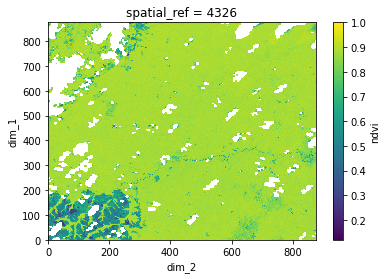

In [54]:
xarr['ndvi'] = ndvi(xarr.red,xarr.nir)
xarr.ndvi.plot()

In [55]:
xarr.ndvi

<xarray.DataArray 'ndvi' (dim_0: 1, dim_1: 876, dim_2: 876)>
array([[[0.60924092, 0.6449593 , 0.74852652, ..., 0.86501838,
         0.88391778, 0.87464387],
        [0.62769918, 0.61551548, 0.61433787, ..., 0.86200378,
         0.87022901, 0.88383838],
        [0.62015504, 0.62408759, 0.59148936, ..., 0.87655688,
         0.88084841, 0.87418655],
        ...,
        [0.89041757, 0.88771239, 0.8835392 , ..., 0.87685291,
         0.89576403, 0.88100805],
        [0.88854192, 0.88952476, 0.89024087, ..., 0.87699932,
         0.88394768, 0.89354687],
        [0.8869423 , 0.87987406, 0.88193791, ..., 0.86146789,
         0.87095203, 0.87165775]]])
Coordinates:
    spatial_ref  int32 4326
Dimensions without coordinates: dim_0, dim_1, dim_2